In [1]:
#!python3 --version

In [2]:
#!pip3 install dwave-neal

In [110]:
import pandas as pd 
import numpy as np
import neal
from neal import SimulatedAnnealingSampler
from pyqubo import Array, Constraint, Placeholder, solve_qubo
import itertools

%matplotlib inline
import matplotlib.pyplot as plt

In [111]:
X_mushroom = pd.read_csv("./X_l_mushroom.csv", sep=',', index_col=0)
y_mushroom = pd.read_csv('./y_l_mushroom.csv', sep=',', index_col=0)['21']

num_samples = X_mushroom.shape[0]
num_cols = X_mushroom.shape[1]
columns = list(X_mushroom.columns)

y_sum = sum(y_mushroom)


In [112]:
num_samples

16

In [113]:
num_cols

119

In [114]:
y_sum

3

In [115]:
2**num_samples

65536

In [116]:
y_mushroom

5004    0
1039    0
3992    0
6624    0
1916    0
6167    0
3178    1
1232    1
6902    0
5295    1
5648    0
6675    0
6283    0
6690    0
5103    0
7820    0
Name: 21, dtype: int64

-----

In [189]:
#ハットつきの統計量を計算する．

t_0_hat=y_sum

t_j_hat=[]

for i in range(num_cols):
    t_j_hat.append(np.dot(X_mushroom.iloc[:,i], y_mushroom))

print('t_0_hat = ', t_0_hat)

print('t_j_hat = ', t_j_hat)

t_0_hat =  3
t_j_hat =  [0, 3, 2, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 2, 0, 1, 3, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 2, 1, 0, 2, 0, 0, 0, 3, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 2, 0, 3, 0, 0, 0, 3, 0, 0, 2, 1, 0, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1]
119


In [201]:
#対象とするインデックスを決める．津田先生のノートだと"1"を意味する．

target_index=2

target_X=X_mushroom.iloc[:,target_index]

target_t_j_hat=t_j_hat[target_index]

print('target index =', target_index)
print('target t_0_hat =', t_0_hat)
print('target t_j_hat =', target_t_j_hat)

target index = 2
target t_0_hat = 3
target t_j_hat = 2


In [268]:
#全列挙
#t_0以外に制約を一個だけ加える．津田先生のノートだと"j"
#j=target_indexは禁止されている（津田先生ノート参照）

#入れたい制約のインデックス．　例）糖尿病患者の性別
j=4

print('constraint index =', j)
print('constraint t_j_hat =', t_j_hat[j])

y_list_all = itertools.product('01', repeat=num_samples)

count=0  #制約を満たす解の個数

count2=0 #そのうち，target t_j_hatよりも大きな値となる解の個数

for y_tuple in y_list_all:
    y_list_list = [int(n) for n in list(y_tuple)]
    
    y = pd.Series(y_list_list)
    
    t_0=sum(y)
    t_j=np.dot(X_mushroom.iloc[:,j], y)
    
    if t_0 ==  t_0_hat and t_j == t_j_hat[j]:
        count= count+1
        #if np.dot(target_X, y) > target_t_j_hat:
        if np.dot(target_X, y) >= target_t_j_hat:  #イコール入れるかどうかわからない．
            count2=count2+1

print('number of solutions =', count)
print('number of solutions (larger than hat) =', count2)
print('p-value =', count2/count)

exact_p_value= count2/count

constraint index = 4
constraint t_j_hat = 0
number of solutions = 560
number of solutions (larger than hat) = 440
p-value = 0.7857142857142857


In [269]:
#SA
y = Array.create('y', shape=num_samples, vartype='BINARY')

#QUBO式で定式化
H = (sum(y) - t_0_hat)**2+(np.dot(X_mushroom.iloc[:,j],y)-t_j_hat[j])**2

qb = H.compile().to_qubo()

sampler = neal.SimulatedAnnealingSampler()


num_sampling=[10,20,50,100,200,500,1000]

mean_p_value=[]
std_p_value=[]


for id_samp in range(len(num_sampling)):

    p_value=[]

    for ind in range(16):

        res = sampler.sample_qubo(qb[0], seed=1234+ind, num_reads=num_sampling[id_samp], num_sweeps=1000)

        tt = 0
        tt2 = 0
        for y_info in list(res.record):
            if sum(y_info[0]) == t_0_hat and np.dot(X_mushroom.iloc[:,j], y_info[0]) == t_j_hat[j]:
                tt = tt + 1
                #if np.dot(target_X, y_info[0]) > target_t_j_hat:
                if np.dot(target_X, y_info[0]) >= target_t_j_hat: #イコール入れるかどうかわからない．
                    tt2 =tt2 +1
                
        if tt ==0:
            p_value.append(0.0)
        else:
            p_value.append(tt2/tt)
                
    print('number of sampling = ', num_sampling[id_samp])                
    print('p-value =', np.mean(p_value), '±', np.std(p_value))
    
    mean_p_value.append(np.mean(p_value))
    std_p_value.append(np.std(p_value))

number of sampling =  10
p-value = 0.7402777777777778 ± 0.12483785780259427
number of sampling =  20
p-value = 0.7833881578947369 ± 0.0973049168355534
number of sampling =  50
p-value = 0.7859438775510204 ± 0.05961052417885592
number of sampling =  100
p-value = 0.794861111111111 ± 0.046010390332168645
number of sampling =  200
p-value = 0.7943121859296483 ± 0.0348509239593451
number of sampling =  500
p-value = 0.7897727955911824 ± 0.01848101216081552
number of sampling =  1000
p-value = 0.7870735735735737 ± 0.014874303713182439


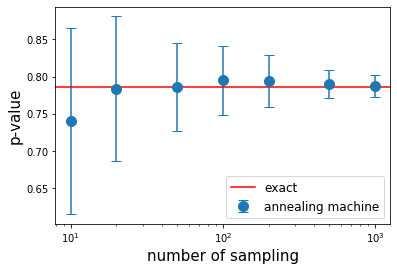

In [270]:
plt.figure()
plt.errorbar(num_sampling,mean_p_value, yerr=std_p_value, capsize=5, fmt='o', markersize=10, label="annealing machine")
plt.axhline(y=exact_p_value, color = 'red', label="exact")
plt.xscale('log')

plt.legend(loc='lower right', fontsize=12)
plt.xlabel('number of sampling', fontsize=15)
plt.ylabel('p-value', fontsize=15)
plt.show()